It is your job to predict the sales price for each house. 
For each Id in the test set, you must predict the value of the SalePrice variable. 

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. 
https://en.wikipedia.org/wiki/Root-mean-square_deviation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn import metrics


import warnings
warnings.simplefilter("ignore")

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv') 
df_train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
df_train.isna().sum().sum()

6965

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Найдем коэффициент корреляции каждого столбца с ценой
df_corr = pd.DataFrame()
for ind, i in enumerate(df_train.columns[0:-1]):
    try:
        corr = np.corrcoef(df_train['SalePrice'], df_train[i])[0, 1]
        p = pd.DataFrame({'indcol': [ind], 'col': [i], 'corr': [corr]})
        df_corr = df_corr.append(p)
    except:
        p = pd.DataFrame({'indcol': [ind], 'col': [i]})
        df_corr = df_corr.append(p)

# Сделаем столбец с модулем корреляции
df_corr['abs_corr'] = np.abs(df_corr['corr'])
df_corr = df_corr.sort_values('abs_corr', ascending=False)
df_corr

,indcol,col,corr,abs_corr
0,17,OverallQual,0.790982,0.790982
0,46,GrLivArea,0.708624,0.708624
0,61,GarageCars,0.640409,0.640409
0,62,GarageArea,0.623431,0.623431
0,38,TotalBsmtSF,0.613581,0.613581
...,...,...,...,...
0,72,PoolQC,NaN,NaN
0,73,Fence,NaN,NaN
0,74,MiscFeature,NaN,NaN
0,78,SaleType,NaN,NaN


In [6]:
# Получим список фич, где корреляция меньше 0.1
df_corr_notna = df_corr.dropna()
barrier = float(input('barrier = '))
drop_f = list(df_corr_notna[~(df_corr_notna['abs_corr'] > barrier)]['col'])
print(drop_f)
# Оставшиеся фичи могут пойти в обучение

barrier = 0.1
['PoolArea', 'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


In [7]:
problem_df = df_train.isnull().sum().sort_values(ascending=False)
print(problem_df)
# Исключим первые 5, т.к. слишком много пропусков
problem_list = list(problem_df.index[0:6])
problem_list

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64


['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']

In [8]:
# Есть проблема, оставшиеся фичи не численные и их много 
df_problem = df_corr[df_corr['corr'].isna()]
drop_NaN = list(df_problem[df_problem['corr'].isna()]['col'])
drop_NaN 

['MSZoning',
 'LotFrontage',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

## Input date

In [9]:
rs = 5
X = df_train.drop(drop_f + drop_NaN + ['SalePrice', 'Id'], axis = 1)
y = df_train['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = rs)

## Baseline

In [10]:
# Попробуем 'тупую' модель только на выбранный скоррелированных данных

In [11]:
clf_tree = tree.DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state = rs)
clf_tree_reg = tree.DecisionTreeRegressor(max_depth=5, random_state = rs)
clf_Ridge = linear_model.Ridge(alpha=1, random_state = rs)
clf_Lasso= linear_model.Lasso(alpha=1, random_state = rs)
clf_linear = linear_model.LinearRegression()
# clf_log_reg = linear_model.LogisticRegression('l2')
list_clf = [clf_tree, clf_tree_reg, clf_Ridge, clf_Lasso, clf_linear]

In [12]:
def baseline_fit(clf, X=X_train, y=y_train, X_t=X_test, y_t=y_test):
    clf.fit(X, y)
    print(clf.score(X_t, y_t))
    print(metrics.mean_squared_error(y_t, clf.predict(X_t), squared=False))


In [13]:
for i in list_clf:
    print(i)
    baseline_fit(i)
    print(' ')

DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=5)
0.012448132780082987
57806.58332093901
 
DecisionTreeRegressor(max_depth=5, random_state=5)
0.7434174816500432
38017.28755187841
 
Ridge(alpha=1, random_state=5)
0.7890412819419222
34471.9883924821
 
Lasso(alpha=1, random_state=5)
0.7888781365707901
34485.315308974205
 
LinearRegression()
0.7888590662522396
34486.872776986296
 


### Исключаем ненужные столбцы 

In [14]:
print(problem_list) # это столбци с болшим количеством пропусков, его точно надо исключить 

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage']


In [15]:
print(drop_f) # это столбцы с коэффициентом корреляции меньше 0.1 , их тоже исключаем 

['PoolArea', 'MSSubClass', 'OverallCond', 'MoSold', '3SsnPorch', 'YrSold', 'LowQualFinSF', 'Id', 'MiscVal', 'BsmtHalfBath', 'BsmtFinSF2']


In [16]:
nominative_list = []
for i in drop_NaN:
    if i not in problem_list:
        nominative_list.append(i)
print(len(nominative_list))
print(nominative_list)


40
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


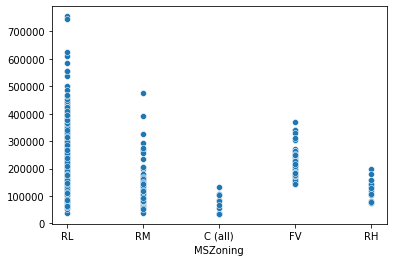

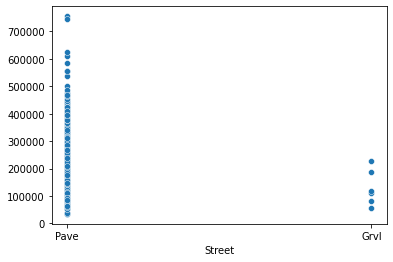

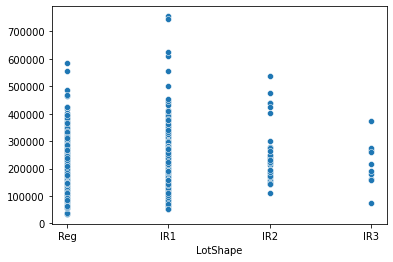

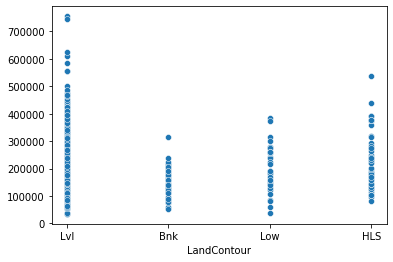

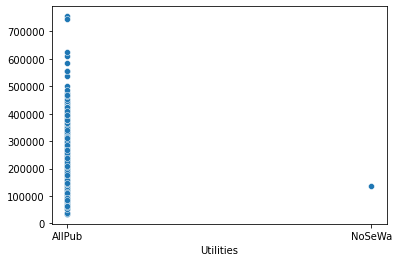

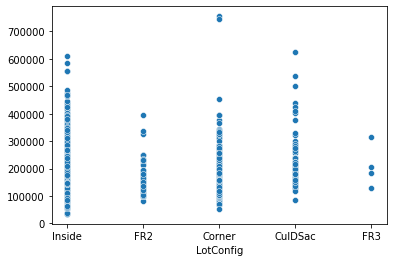

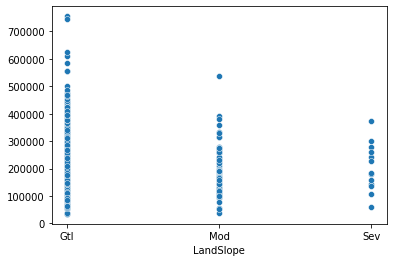

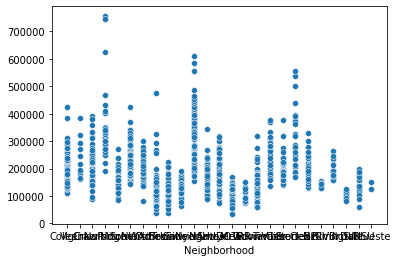

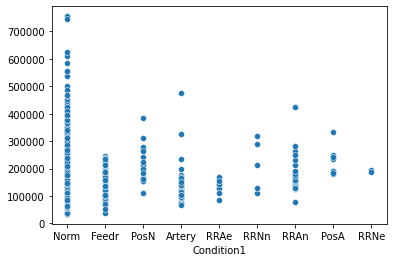

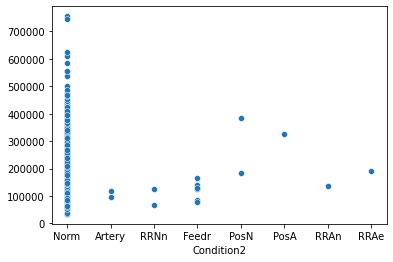

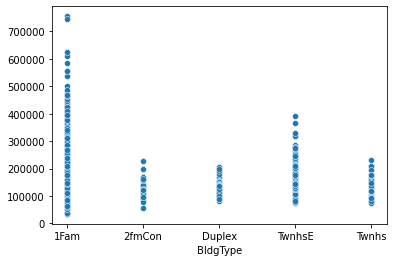

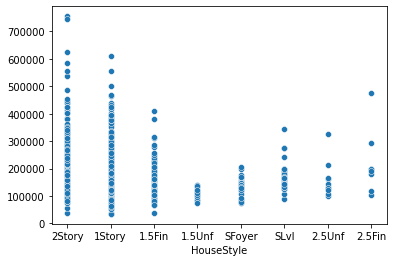

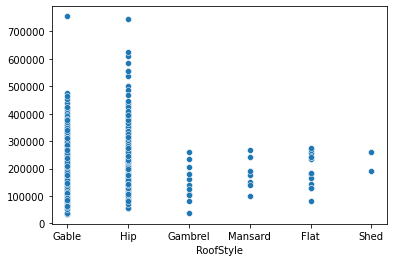

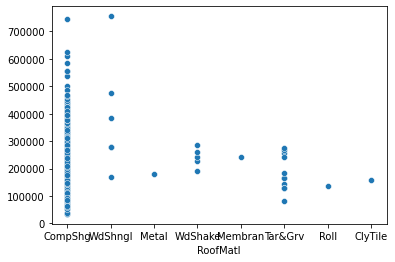

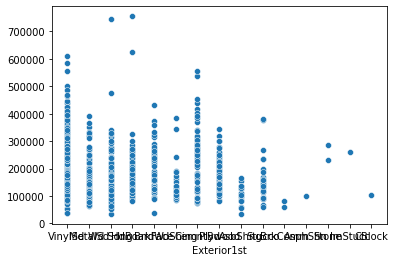

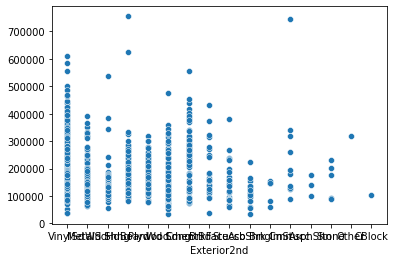

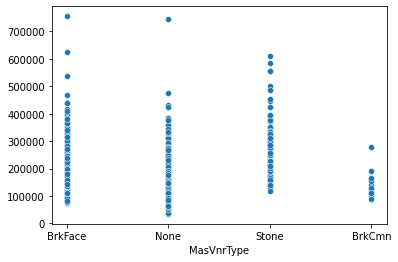

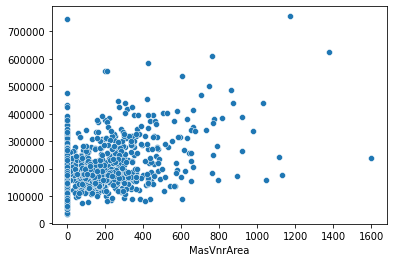

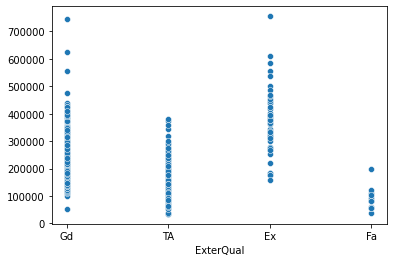

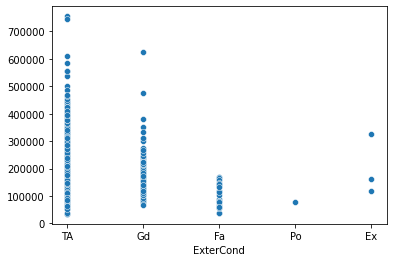

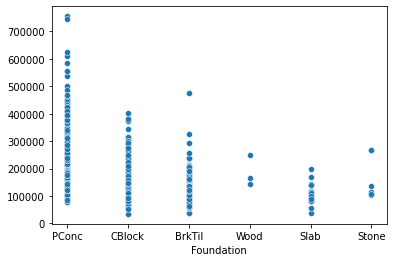

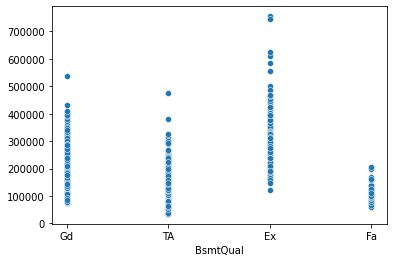

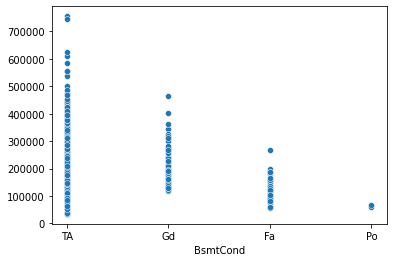

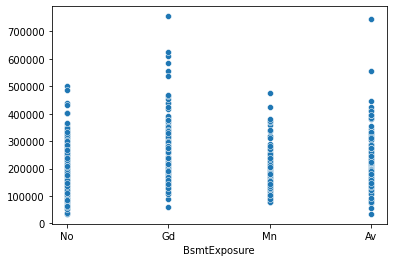

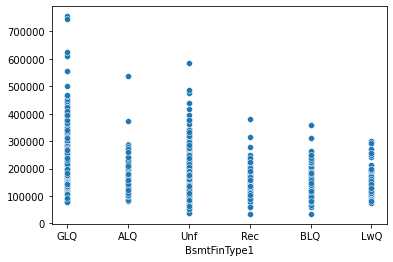

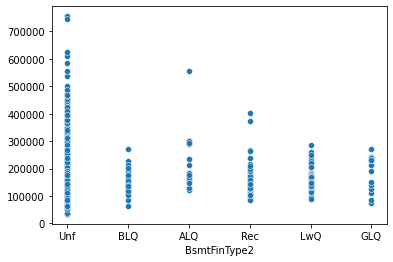

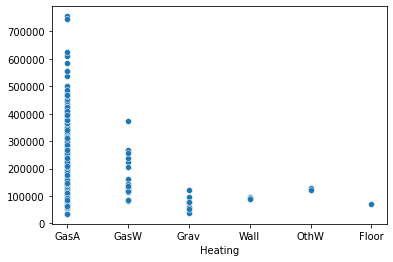

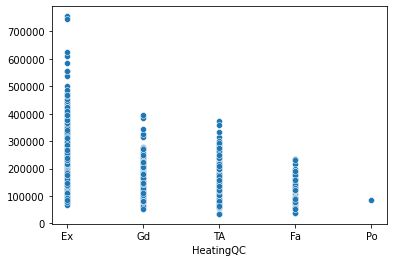

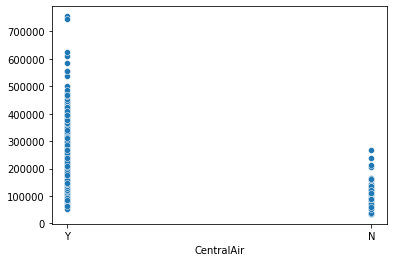

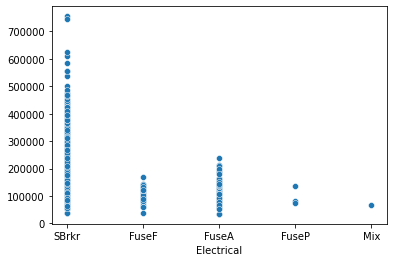

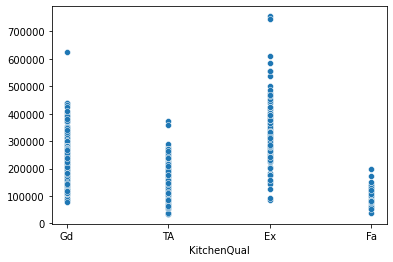

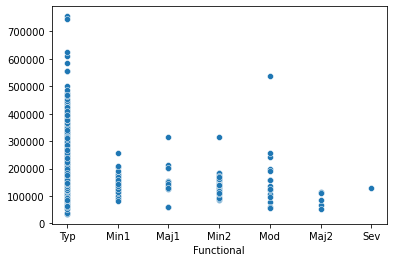

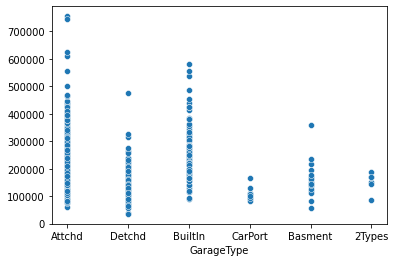

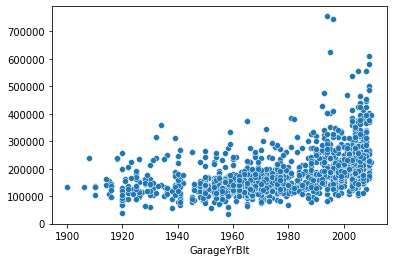

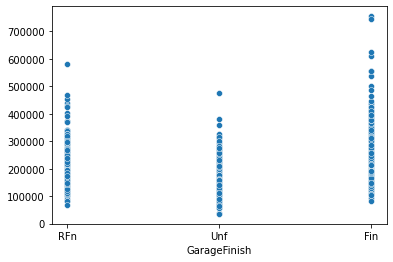

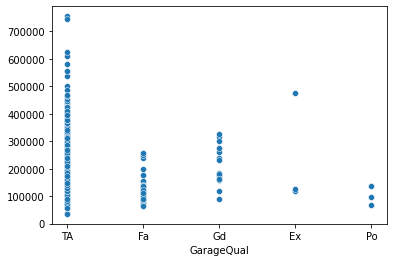

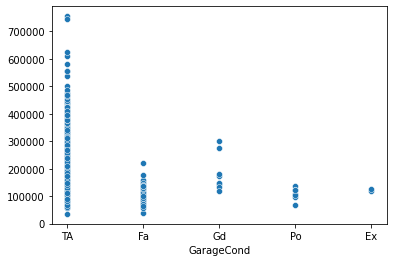

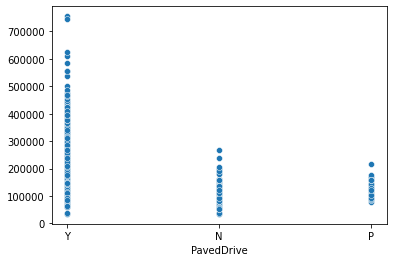

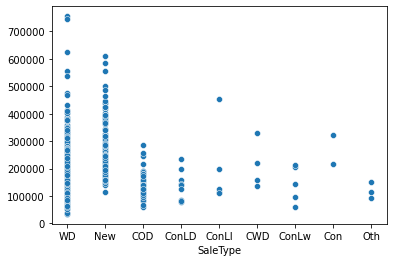

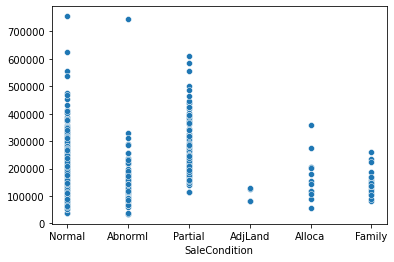

In [17]:
for i in nominative_list:
    sns.scatterplot(x = df_train[i], y = list(df_train['SalePrice']))
    plt.show()

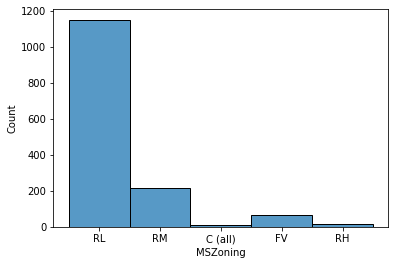

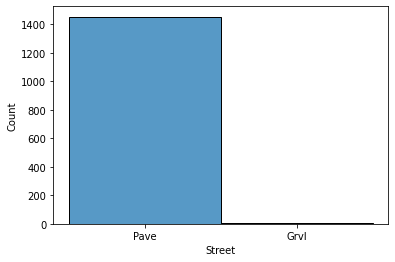

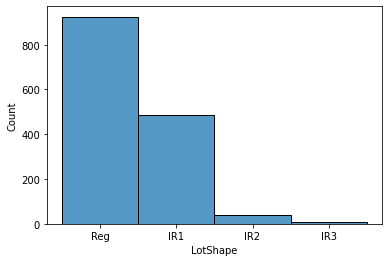

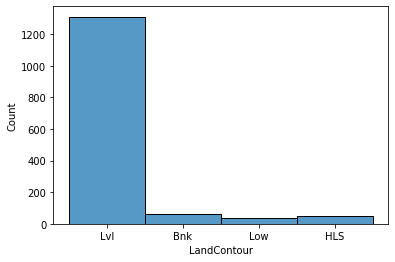

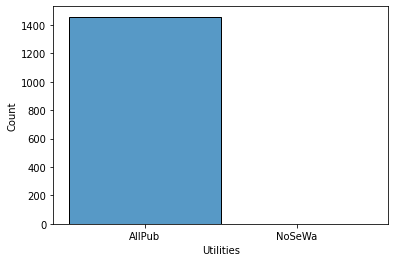

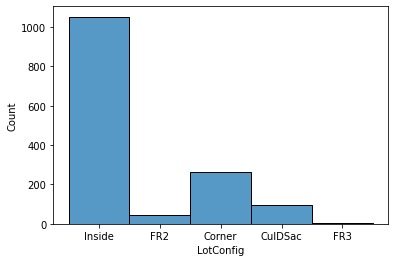

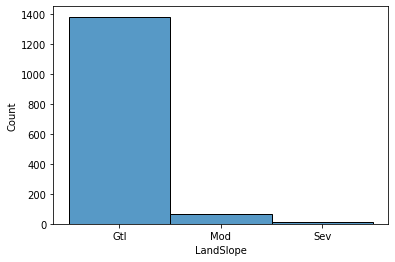

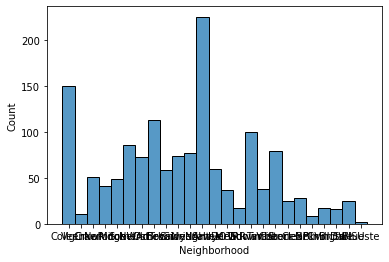

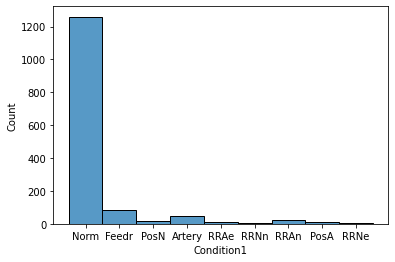

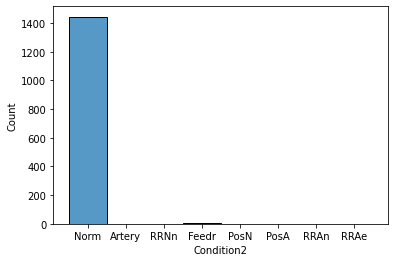

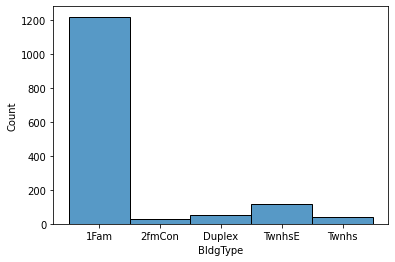

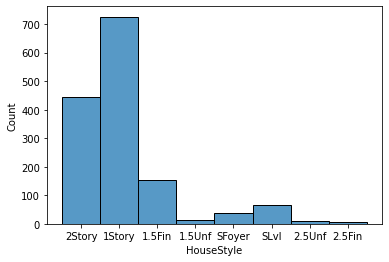

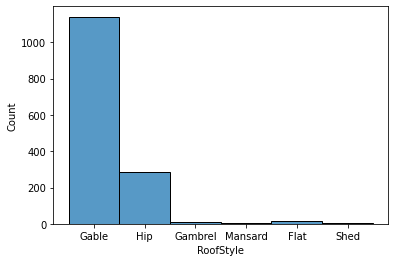

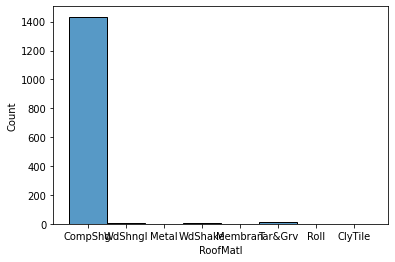

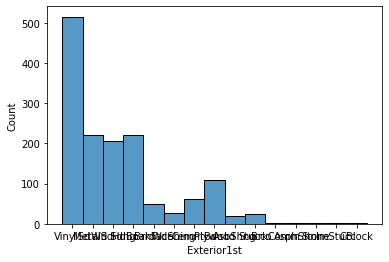

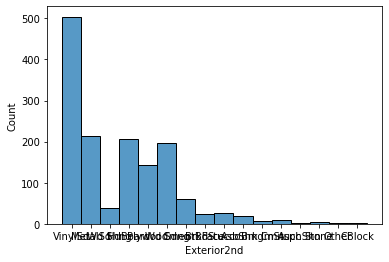

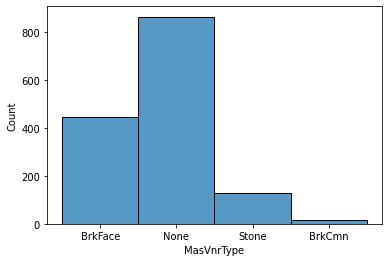

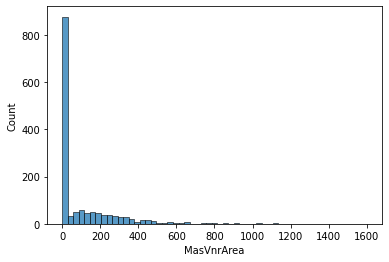

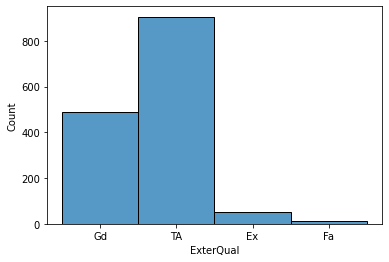

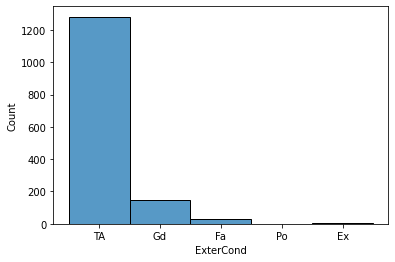

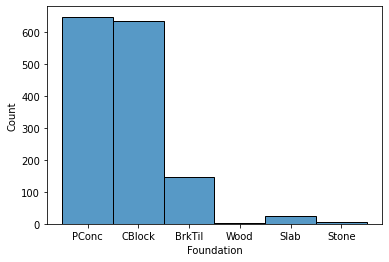

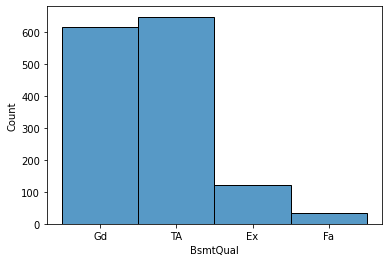

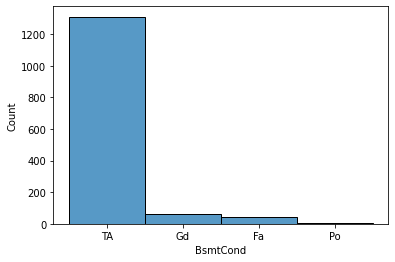

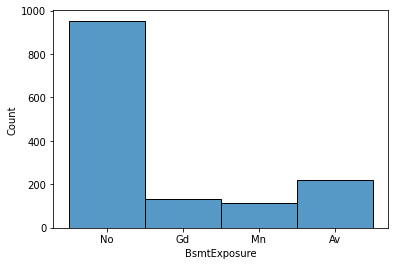

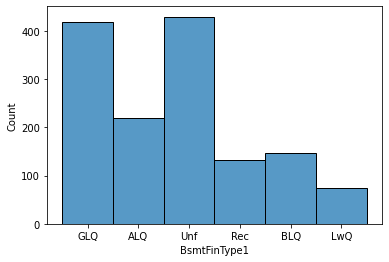

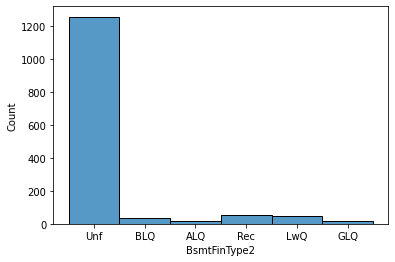

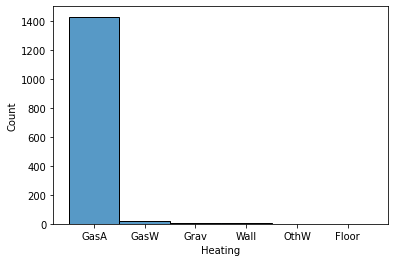

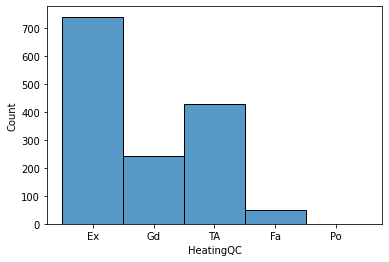

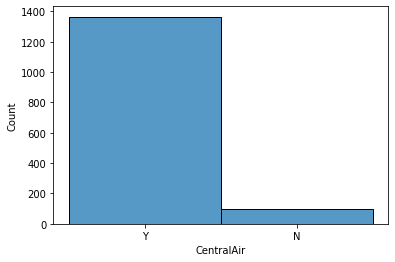

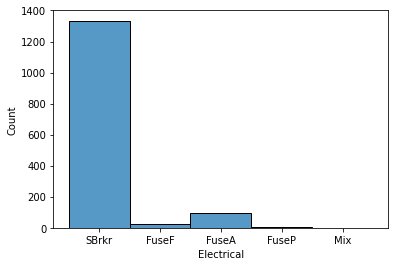

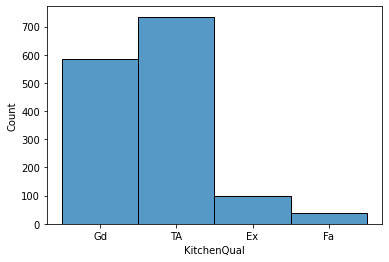

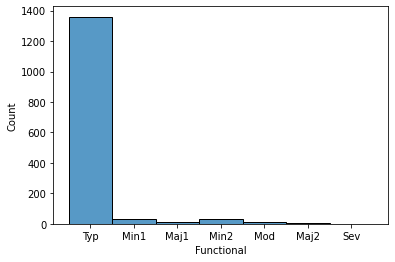

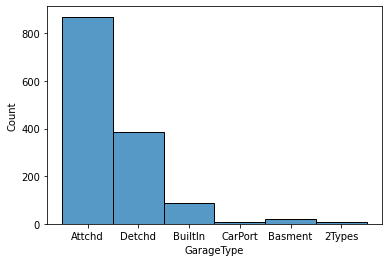

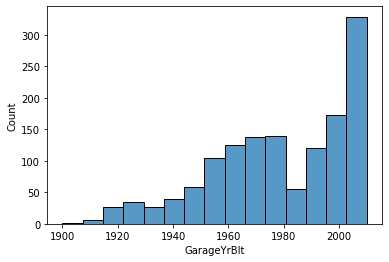

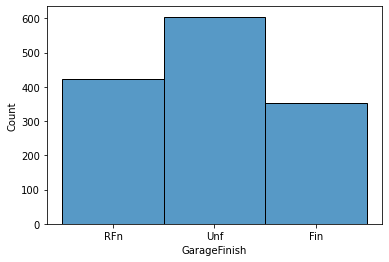

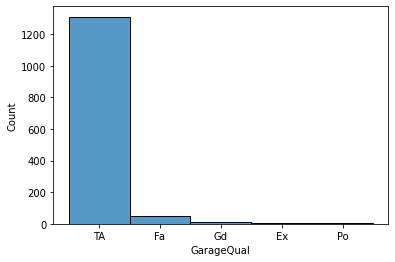

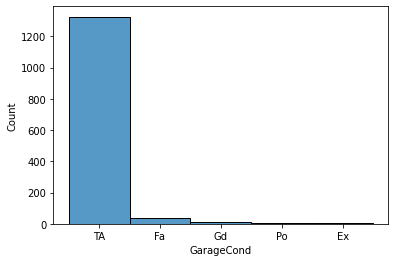

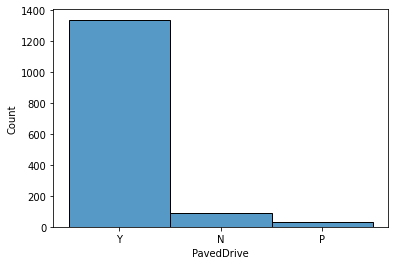

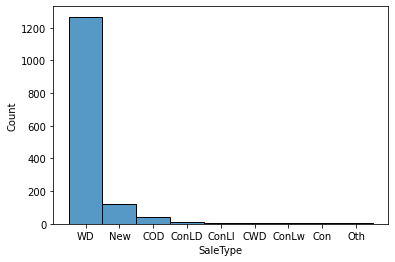

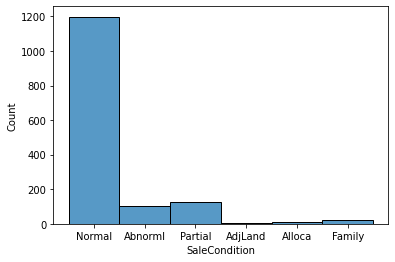

In [18]:
for i in nominative_list:
    sns.histplot(x = df_train[i])
    plt.show()

In [19]:
bad_list = ['Utilities','Condition2', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual']